## Homework 2  - Questions 3 and 4: Lotka-Volterra and SINDy models
Michelle Hu  
---
University of Washington  
AMATH 563  
Homework 2  
Due: May 6, 2020  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
wd = "/mnt/Backups/jmhu"
data_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/data/"
model_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/models/"
fig_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/figures/"

### Load data

In [4]:
df = pd.read_csv(data_dir+"population_data.csv")
df.head()

,Year,Hare,Lynx
0,1845,20,32
1,1847,20,50
2,1849,52,12
3,1851,83,10
4,1853,64,13


#### Define functions

In [5]:
def lotka_volterra(t, x0, b, p, r, d):
    '''Empirical Lotka-Volterra predator-prey model'''
    x, y = x0
    xdot = (b - p*y) * x
    ydot = (r*x - d) * y
    return(xdot, ydot)


def densify(t, y, dt):
    from scipy.interpolate import interp1d
    f = interp1d(t, y, kind='cubic')
    tnew = np.arange(t[0], t[-1], dt)
    ynew = f(tnew)
    return(tnew, ynew)

#### Figure formatting

In [6]:
y_position=0.92
fontsize=16
weight="bold"

## Question 3. Empirical Predator-Prey models such as Lotka-Volterra are commonly used to model such phenomenon. Consider the model x ̇ = (b − py)x and y ̇ = (rx − d)y. Use the data to fit values of b, p, r and d.


### APPROACH: Use SINDy with limited library to fit values for b, p, r and d using the data

#### Set up problem and calculate time derivatives

In [7]:
# Set up problem
X=df.Hare.values
Y=df.Lynx.values

make_it_dense = 5

t = df.Year.values
dt = (t[1] - t[0])/make_it_dense # make 5 times more points

# Interpolate for more points
years, X = densify(t, X, dt)
years, Y = densify(t, Y, dt)

# Calculate derivatives with center point finite difference
xdot=np.zeros_like(X)
ydot=np.zeros_like(Y)

for j in range(len(xdot)-1):
    if j == 0:
        pass
    else:
        xdot[j-1] = ( X[j+1]-X[j-1] ) / (2*dt)
        ydot[j-1] = ( Y[j+1]-Y[j-1] ) / (2*dt)
        
X.shape, Y.shape, xdot.shape, ydot.shape

((145,), (145,), (145,), (145,))

#### Reshape only with endpoints

In [8]:
# Toss endpoints
X=X[1:-1]
Y=Y[1:-1]
xdot=xdot[:-2]
ydot=ydot[:-2]

X.shape, Y.shape, xdot.shape, ydot.shape

((143,), (143,), (143,), (143,))

#### Create library of restricted potential functions

In [9]:
AX = np.array([ X, X*Y])
AX_names = np.array([ "X", "XY"])

AY = np.array([ Y, X*Y])
AY_names = np.array([ "Y", "XY"])
AX.shape, len(AX_names), AY.shape, len(AY_names)

((2, 143), 2, (2, 143), 2)

#### Use linear regression with L1 normalization to find coefficient weights

In [10]:
%%time

hare_models = []
lynx_models = []

from sklearn import linear_model

# LASSO
lasso=linear_model.Lasso(random_state=43, max_iter=100000000)
lasso.fit(AX.T, xdot)
Xi_lasso=lasso.coef_
hare_models.append(lasso)

lasso=linear_model.Lasso(random_state=43, max_iter=100000000)
lasso.fit(AY.T, ydot)
Yi_lasso=lasso.coef_
print(Xi_lasso.shape, Yi_lasso.shape)
lynx_models.append(lasso)

# LASSO 0.8 alpha
lasso=linear_model.Lasso(random_state=43, max_iter=100000000, alpha=0.8)
lasso.fit(AX.T, xdot)
Xi_lasso8=lasso.coef_
hare_models.append(lasso)

lasso=linear_model.Lasso(random_state=43, max_iter=100000000, alpha=0.8)
lasso.fit(AY.T, ydot)
Yi_lasso8=lasso.coef_
print(Xi_lasso8.shape, Yi_lasso8.shape)
lynx_models.append(lasso)

# Least Angle Regression
lars = linear_model.LassoLars()
lars.fit(AX.T, xdot)
Xi_lars=lars.coef_
hare_models.append(lars)

lars = linear_model.LassoLars()
lars.fit(AY.T, ydot)
Yi_lars=lars.coef_
print(Xi_lars.shape, Yi_lars.shape)
lynx_models.append(lars)

(2,) (2,)
(2,) (2,)
(2,) (2,)
CPU times: user 165 ms, sys: 12.3 ms, total: 177 ms
Wall time: 177 ms


#### Plot weightings of solutions

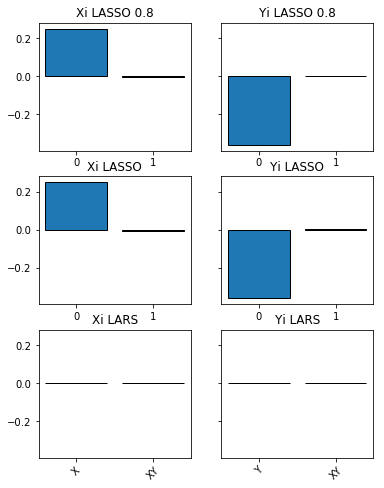

In [11]:
ec='k'

fig, ax = plt.subplots(3, 2, figsize=(6, 8), sharey=True)

# Xi 1 solutions
ax[0,0].bar(np.arange(len(AX)), Xi_lasso8, ec=ec, )
ax[1,0].bar(np.arange(len(AX)), Xi_lasso, ec=ec)
ax[2,0].bar(np.arange(len(AX)), Xi_lars, ec=ec)
ax[0,0].set_title("Xi LASSO 0.8")
ax[1,0].set_title("Xi LASSO")
ax[2,0].set_title("Xi LARS")

# Xi 2 solutions
ax[0,1].bar(np.arange(len(AY)), Yi_lasso8, ec=ec)
ax[1,1].bar(np.arange(len(AY)), Yi_lasso, ec=ec)
ax[2,1].bar(np.arange(len(AY)), Yi_lars, ec=ec)
ax[0,1].set_title("Yi LASSO 0.8")
ax[1,1].set_title("Yi LASSO")
ax[2,1].set_title("Yi LARS");

ticks=np.arange(len(AX_names))
rotation=45

ax[0,0].set_xticks(ticks)
ax[0,1].set_xticks(ticks)
ax[1,0].set_xticks(ticks)
ax[1,1].set_xticks(ticks)

ax[2,0].set_xticks(ticks)
ax[2,0].set_xticklabels(AX_names, rotation=rotation);

ax[2,1].set_xticks(ticks)
ax[2,1].set_xticklabels(AY_names, rotation=rotation);

#### Extract thresholded coefficients of models (L1 normalization)

In [12]:
thresh=1e-3

X_coefs = [Xi_lasso8, Xi_lasso, Xi_lars]
Y_coefs = [Yi_lasso8, Yi_lasso, Yi_lars]
models = ["lasso8", "lasso", "lars"]

for xi, yi, model in zip(X_coefs, Y_coefs, models):
    print(model)
    
    print("=== xdot dependent on: ===")
    for idx, j, in enumerate(np.abs(xi)>thresh):
            if j:
                print("{0:.4f}".format(xi[idx]), AX_names[idx])

    print("=== ydot dependent on: ===")
    for idx, k, in enumerate(np.abs(yi)>thresh):
        if k:
            print("{0:.4f}".format(yi[idx]), AY_names[idx])
    print("\n")

lasso8
=== xdot dependent on: ===
0.2513 X
-0.0054 XY
=== ydot dependent on: ===
-0.3598 Y
0.0034 XY


lasso
=== xdot dependent on: ===
0.2511 X
-0.0054 XY
=== ydot dependent on: ===
-0.3583 Y
0.0034 XY


lars
=== xdot dependent on: ===
=== ydot dependent on: ===




### Forecast population numbers based on Lasso coefficients

In [13]:
from scipy.integrate import solve_ivp

# Set up time span
t_range = [0, len(years)]

# instantiate initial conditions
x0 = (X[0], Y[0])

# Extract coefficients
b, p = np.abs(Xi_lasso)
d, r = np.abs(Yi_lasso)

In [14]:
t_range, x0

([0, 145], (16.519635587166537, 46.34619543994153))

In [15]:
b, p, r, d

(0.25105810750119606,
 0.005395627986256525,
 0.0034032654490288865,
 0.3583315365019902)

#### Derive IVP solution 

In [16]:
sol = solve_ivp(lotka_volterra, t_range, x0, 
                args=(b, p, r, d), dense_output=True)

t = np.arange(0, len(years), 1)
predictions = sol.sol(t)

In [17]:
t.shape, years

((145,), array([1845. , 1845.4, 1845.8, 1846.2, 1846.6, 1847. , 1847.4, 1847.8,
        1848.2, 1848.6, 1849. , 1849.4, 1849.8, 1850.2, 1850.6, 1851. ,
        1851.4, 1851.8, 1852.2, 1852.6, 1853. , 1853.4, 1853.8, 1854.2,
        1854.6, 1855. , 1855.4, 1855.8, 1856.2, 1856.6, 1857. , 1857.4,
        1857.8, 1858.2, 1858.6, 1859. , 1859.4, 1859.8, 1860.2, 1860.6,
        1861. , 1861.4, 1861.8, 1862.2, 1862.6, 1863. , 1863.4, 1863.8,
        1864.2, 1864.6, 1865. , 1865.4, 1865.8, 1866.2, 1866.6, 1867. ,
        1867.4, 1867.8, 1868.2, 1868.6, 1869. , 1869.4, 1869.8, 1870.2,
        1870.6, 1871. , 1871.4, 1871.8, 1872.2, 1872.6, 1873. , 1873.4,
        1873.8, 1874.2, 1874.6, 1875. , 1875.4, 1875.8, 1876.2, 1876.6,
        1877. , 1877.4, 1877.8, 1878.2, 1878.6, 1879. , 1879.4, 1879.8,
        1880.2, 1880.6, 1881. , 1881.4, 1881.8, 1882.2, 1882.6, 1883. ,
        1883.4, 1883.8, 1884.2, 1884.6, 1885. , 1885.4, 1885.8, 1886.2,
        1886.6, 1887. , 1887.4, 1887.8, 1888.2, 1888.6, 

In [18]:
predictions.shape

(2, 145)

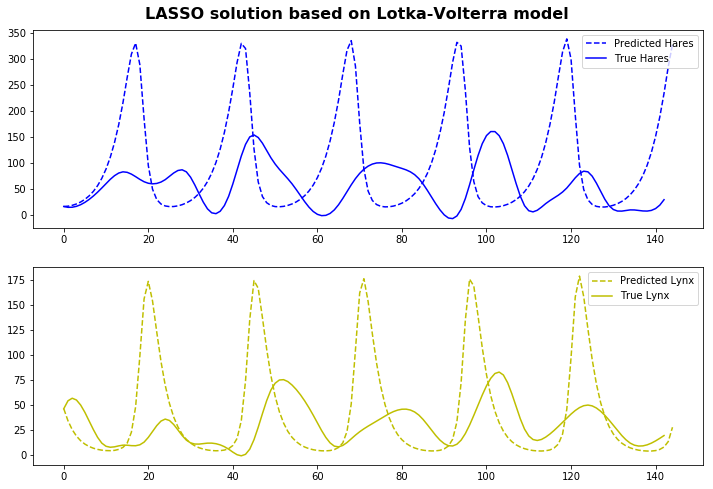

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(t, predictions[0].T, "b--", label="Predicted Hares")
axes[0].plot(X, "b", label="True Hares")

axes[1].plot(t, predictions[1].T, "y--", label="Predicted Lynx")
axes[1].plot(Y, "y", label="True Lynx")
for ax in axes:
    ax.legend()
    
plt.suptitle("LASSO solution based on Lotka-Volterra model", 
             y=y_position, fontsize=fontsize, weight=weight);

### Using Lotka-Volterra model, add paper control u(t)

In [20]:
def lotka_volterra_control(t, x0, b, p, r, d):
    '''Empirical Lotka-Volterra predator-prey model with SINDy-derived weightings 
    and published control function from https://arxiv.org/pdf/1605.06682.pdf'''
    x, y = x0
    xdot = (b - p*y) * x + (2*np.sin(t) + 2*np.sin(t/10))**2
    ydot = (r*x - d) * y
    
    return(xdot, ydot)

#### Derive IVP predictions

In [21]:
sol = solve_ivp(lotka_volterra_control, t_range, x0, 
                args=(b, p, r, d), dense_output=True)

t = np.arange(0, len(years), 1)
predictions = sol.sol(t)

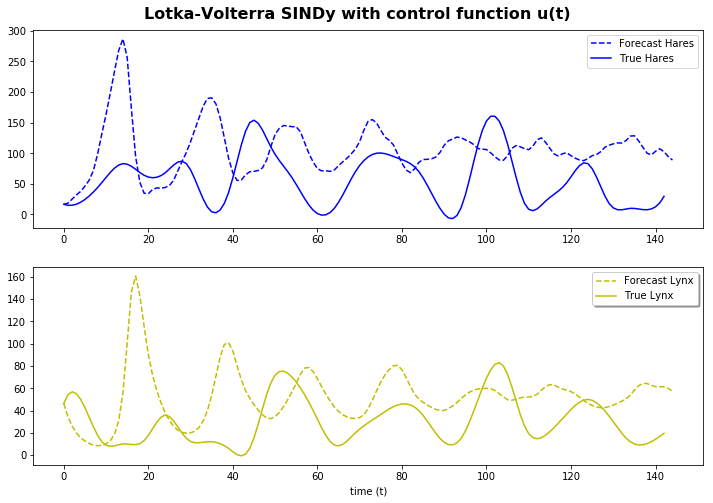

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(t, predictions[0].T, "b--", label="Forecast Hares")
axes[0].plot(X, "b", label="True Hares")

axes[1].plot(t, predictions[1].T, "y--", label="Forecast Lynx")
axes[1].plot(Y, "y", label="True Lynx")

for ax in axes:
    ax.legend()

plt.xlabel('time (t)')
plt.suptitle("Lotka-Volterra SINDy with control function u(t)",
             y=y_position, fontsize=fontsize, weight=weight);

plt.legend(shadow=True)
plt.show()

### Save Lotka-Volterra models

#### Set up model filenames

In [23]:
ending = "_" + str(make_it_dense) + "pts_" + str(int(thresh*1000))

model_fns = ["lasso", "lasso8", "lars"]
model_fns = [model_dir + model + "_LV" for model in model_fns]

hare_model_fns = [ model + ending + "_hare.pkl" for model in model_fns]
lynx_model_fns = [ model + ending + "_lynx.pkl" for model in model_fns]

#### Use pickle to dump to file

In [24]:
for hare_fn, lynx_fn, hare_model, lynx_model in zip(hare_model_fns, lynx_model_fns, hare_models, lynx_models):
    if not os.path.exists(hare_fn):
        with open(hare_fn, "wb") as file:
            pickle.dump(hare_model, file)   
    else:
        print(hare_fn.split('/')[-1][:-4], "exists")
    if not os.path.exists(lynx_fn):
        with open(lynx_fn, "wb") as file:
            pickle.dump(lynx_model, file)    
    else:
        print(lynx_fn.split('/')[-1][:-4], "exists")

lasso_LV_5pts_1_hare exists
lasso_LV_5pts_1_lynx exists
lasso8_LV_5pts_1_hare exists
lasso8_LV_5pts_1_lynx exists
lars_LV_5pts_1_hare exists
lars_LV_5pts_1_lynx exists


#### Note: control model coefficients are saved with the LASSO_LV models --> u(t) is separate component

---

## Question 4. Find the best fit nonlinear, dynamical systems model to the data using sparse regression.

In [25]:
# Set up problem
x1=df.Hare.values
x2=df.Lynx.values
t = df.Year.values

# Interpolate for more points
dt = (t[1] - t[0])/make_it_dense

years, x1 = densify(t, x1, dt)
years, x2 = densify(t, x2, dt)

# Calculate derivatives with center point finite difference
dx1=np.zeros_like(x1)
dx2=np.zeros_like(x2)

for j in range(len(dx1)-1):
    if j == 0:
        pass
    else:
        dx1[j-1] = ( x1[j+1]-x1[j-1] ) / (2*dt)
        dx2[j-1] = ( x2[j+1]-x2[j-1] ) / (2*dt)
        
x1.shape, x2.shape, dx1.shape, dx2.shape

((145,), (145,), (145,), (145,))

In [26]:
# Toss endpoints
x1s=x1[1:-1]
x2s=x2[1:-1]
dx1=dx1[:-2]
dx2=dx2[:-2]

x1s.shape, x2s.shape, dx1.shape, dx2.shape

((143,), (143,), (143,), (143,))

In [27]:
# Create library of potential functions
# A = np.array([ x1s, x2s, x1s**2, x1s*x2s, x2s**2, 
#               x1s**3, x1s*x2s**2, x1s**2*x2s, x2s**3, 
#               np.sin(x1s), np.cos(x2s), np.sin(x2s), np.cos(x1s), 
#               np.sin(2*x1s), np.cos(2*x2s), np.sin(2*x2s), np.cos(2*x1s),
#               1/np.sin(x1s), 1/np.cos(x2s), 1/np.sin(x2s), 1/np.cos(x1s),
#               np.cos(np.pi*x1s), np.cos(np.pi*x2s)
#              ])
# A_names=["x1s", "x2s", "x1s**2", "x1s*x2s", "x2s**2", 
#               "x1s**3", "x1s*x2s**2", "x1s**2*x2s", "x2s**3", 
#               "np.sin(x1s)", "np.cos(x2s)", "np.sin(x2s)", "np.cos(x1s)", 
#               "np.sin(2*x1s)", "np.cos(2*x2s)", "np.sin(2*x2s)", "np.cos(2*x1s)",
#               "1/np.sin(x1s)", "1/np.cos(x2s)", "1/np.sin(x2s)", "1/np.cos(x1s)",
#                        "np.cos(np.pi*x1s)", "np.cos(np.pi*x2s)"
#         ]

# A.shape, len(A_names)

AX = np.array([ x1s, x1s*x2s, 1/x1s, 1/x2s])
AX_names = np.array([ "x1s", "x1s*x2s", "1/x1s", "1/x2s"])

AY = np.array([ x1s, x2s, x1s*x2s, 1/x1s, 1/x2s])
AY_names = np.array([ "x1s", "x2s", "x1s*x2s", "1/x1s", "1/x2s"])
AX.shape, len(AX_names), AY.shape, len(AY_names)


((4, 143), 4, (5, 143), 5)

#### Use various solvers with L1 regularization to find function weights

In [28]:
%%time
max_iter=1e3

# LASSO
lasso=linear_model.Lasso(random_state=0, max_iter=max_iter)
lasso.fit(AX.T, dx1)
xi1_lasso=lasso.coef_
hare_models.append(lasso)

lasso=linear_model.Lasso(random_state=0, max_iter=max_iter)
lasso.fit(AY.T, dx2)
xi2_lasso=lasso.coef_
print(xi1_lasso.shape, xi2_lasso.shape)
lynx_models.append(lasso)

(4,) (5,)
CPU times: user 1.73 ms, sys: 0 ns, total: 1.73 ms
Wall time: 1.33 ms


#### Plot weightings of LASSO solution

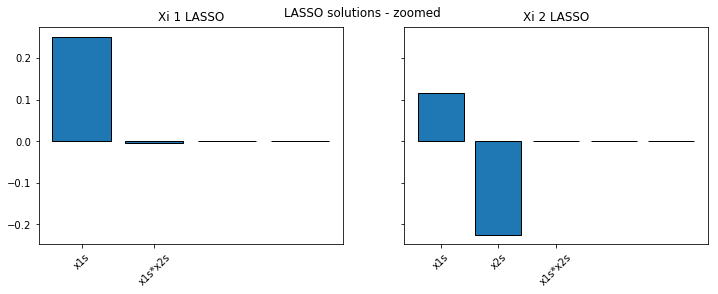

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
plt.subplots_adjust(hspace=0.4)

ax[0].bar(np.arange(len(AX)), xi1_lasso, ec=ec)
ax[0].set_title("Xi 1 LASSO")

ax[1].bar(np.arange(len(AY)), xi2_lasso, ec=ec)
ax[1].set_title("Xi 2 LASSO")

plt.suptitle("LASSO solutions - zoomed", y=0.95);

### ==== Axis ticklabels === ###
thresh=1e-3
rotation=45

def good_functions(xi, thresh, A_name):
    '''First get indices of coefficients larger than threshold
    Then extract library candidate function names based on indices
    '''
    xi_ind=(np.indices(xi.shape).squeeze())[np.abs(xi)>thresh] 
    xi_names=[ A_name[x] for x in xi_ind ] 
    return(xi_ind, xi_names)

# LASSO solutions
xi1_lasso_ind, xi1_lasso_names = good_functions(xi1_lasso, thresh, AX_names)
xi2_lasso_ind, xi2_lasso_names = good_functions(xi2_lasso, thresh, AY_names)

ax[0].set_xticks(xi1_lasso_ind)
ax[0].set_xticklabels(xi1_lasso_names, rotation=rotation)

ax[1].set_xticks(xi2_lasso_ind)
ax[1].set_xticklabels(xi2_lasso_names, rotation=rotation);

#### Extract thresholded coefficients of models

In [30]:
xi1 = xi1_lasso
xi2 = xi2_lasso
models = ["lasso"]

AX_names=np.array(AX_names)
AY_names=np.array(AY_names)

print("LASSO")
print("=== dx1 dependent on: ===")
for idx, j, in enumerate(np.abs(xi1)>thresh):
    if j:
        print("{0:.5f}".format(xi1[idx]), AX_names[idx])

print("=== dx2 dependent on: ===")
for idx, k, in enumerate(np.abs(xi2)>thresh):
    if k:
        print("{0:.5f}".format(xi2[idx]), AY_names[idx])

LASSO
=== dx1 dependent on: ===
0.25106 x1s
-0.00540 x1s*x2s
=== dx2 dependent on: ===
0.11611 x1s
-0.22445 x2s
0.00117 x1s*x2s


#### Build new SINDy model

In [31]:
def new_model(t, x0, a, b, c, d, e):
    '''SINDy model'''
    x, y = x0
    xdot = a*x + b*x*y
    ydot = c*x + d*y + e*x*y
    return(xdot, ydot)

#### Use models and coefficients to predict number of hares and lynx for the given time period

In [32]:
# Compute predicted time derivatives
a, b = xi1_lasso[np.abs(xi1_lasso)>thresh]
c, d, e = xi2_lasso[np.abs(xi2_lasso)>thresh]

x0 =(x1s, x2s)

dx1_hat, dx2_hat = new_model(t=None, x0=x0,
                             a=a, b=b, c=c, d=d,
                             e=e
                            )
# Set up time span for IVP
t_range = [0, len(years)]

# instantiate initial conditions
x0=(x1s[0], x2s[0])

#### Derive IVP solution with SINDy model

In [33]:
%%time
sol = solve_ivp(new_model, t_range, x0, 
                args=(a, b, c, d, e), dense_output=True)

CPU times: user 8.65 ms, sys: 0 ns, total: 8.65 ms
Wall time: 2.52 ms


#### Plot IVP forecast

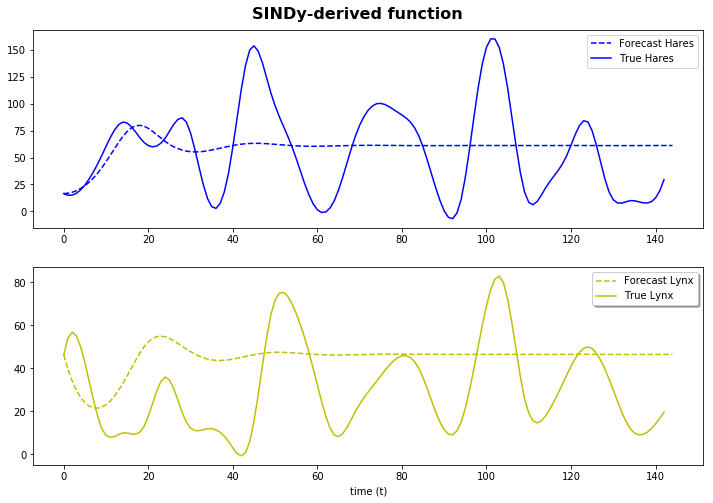

In [34]:
t = np.arange(0, len(years), 1)
predictions = sol.sol(t)


fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(t, predictions[0].T, "b--", label="Forecast Hares")
axes[0].plot(X, "b", label="True Hares")

axes[1].plot(t, predictions[1].T, "y--", label="Forecast Lynx")
axes[1].plot(Y, "y", label="True Lynx")

for ax in axes:
    ax.legend()

plt.xlabel('time (t)')
plt.suptitle("SINDy-derived function",
             y=y_position, fontsize=fontsize, weight=weight);

plt.legend(shadow=True)
plt.show()

#### Save SINDy coefficients

In [35]:
ending = "_" + str(make_it_dense) + "pts_thresh" + str(int(thresh*1000)) + "kth"

SINDY_fn = model_dir + "SINDy_new" + ending + ".pkl"
SINDY_fn

'/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/SINDy_new_5pts_thresh1kth.pkl'

In [36]:
SINDY_coef = [a, b, c, d, e]

In [37]:
if not os.path.exists(SINDY_fn):
    with open(SINDY_fn, "wb") as file:
        pickle.dump(SINDY_coef, file)   
else:
    print(SINDY_fn.split('/')[-1][:-4], "exists")